In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import matplotlib.ticker as ticker
import pandas_profiling
from sklearn.neighbors import KernelDensity

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# EDA

In [ ]:
# Load datasets
train = pd.read_csv('./datasets/cleaned_train.csv')
test = pd.read_csv('./datasets/test.csv')
weather = pd.read_csv('./datasets/cleaned_weather.csv')
spray = pd.read_csv('./datasets/spray.csv')

In [ ]:
merged_df = pd.merge(weather, train, on=['Date', 'Year', 'Week', 'Month', 'DayOfWeek'])

In [ ]:
pandas_profiling.ProfileReport(train)

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# use heatmap to find the correlation
def heatmap(df):
    fix, ax = plt.subplots(figsize=(22,22))

    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(df.corr(), mask=mask, ax=ax, cmap='coolwarm',vmin=-1, vmax=1,
                     square=True, linewidth=1,annot=True,annot_kws={'size':'13'},
                     cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    ax.set_title('Correlation Heatmap for Merged Data', fontsize=22);

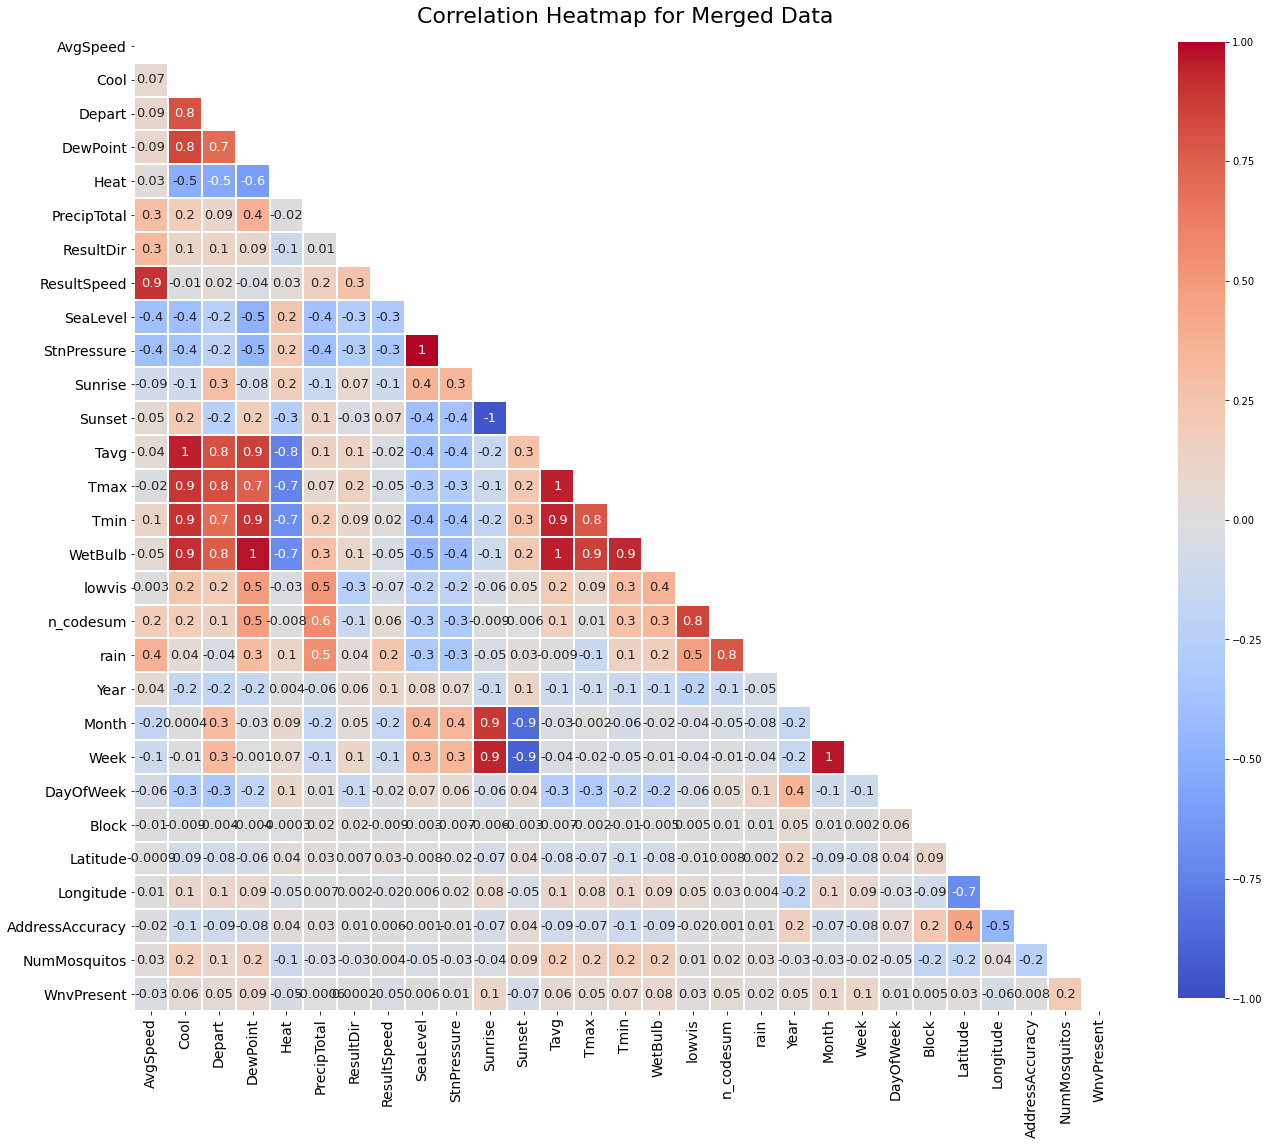

In [ ]:
heatmap(merged_df)

In [ ]:
# Species with West Nile Virus
species_wnv = set((train[train['WnvPresent'] > 0])['Species'])
species_wnv

{'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS'}

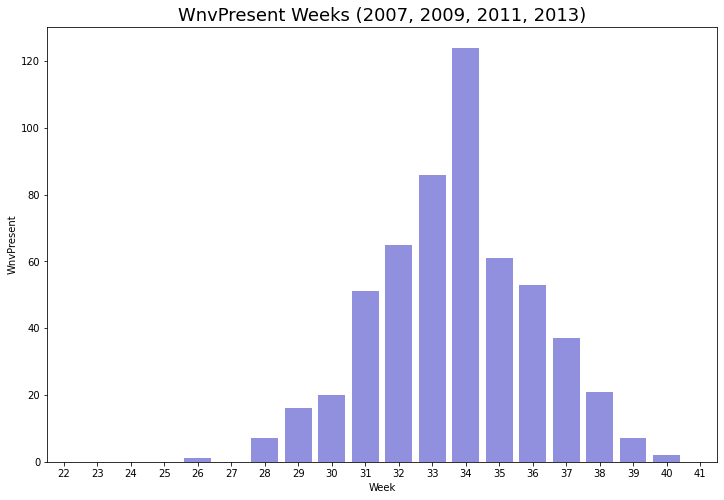

In [ ]:
# Weeks 33-34 tend to have higher incidences of the West Nile Virus
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.barplot(data=train.groupby(by='Week').sum().reset_index(), x='Week', y='WnvPresent', color='#8383EC', ax=ax)
plt.title('WnvPresent Weeks (2007, 2009, 2011, 2013)', fontsize=18);

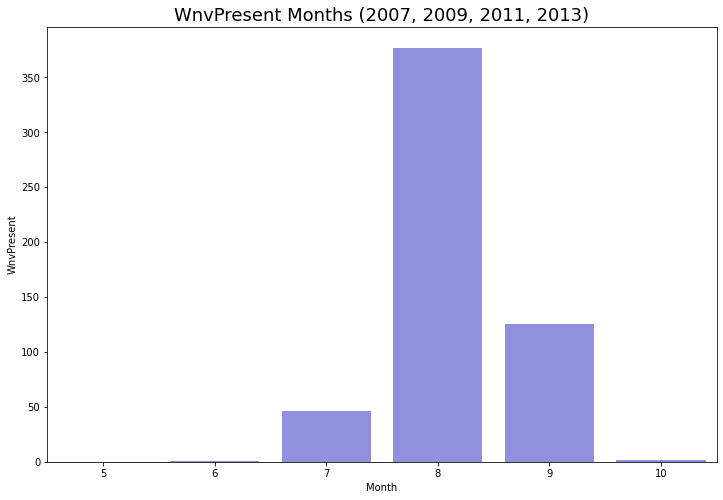

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.barplot(data=train.groupby(by='Month').sum().reset_index(), x='Month', y='WnvPresent', color='#8383EC', ax=ax)
plt.title('WnvPresent Months (2007, 2009, 2011, 2013)', fontsize=18);

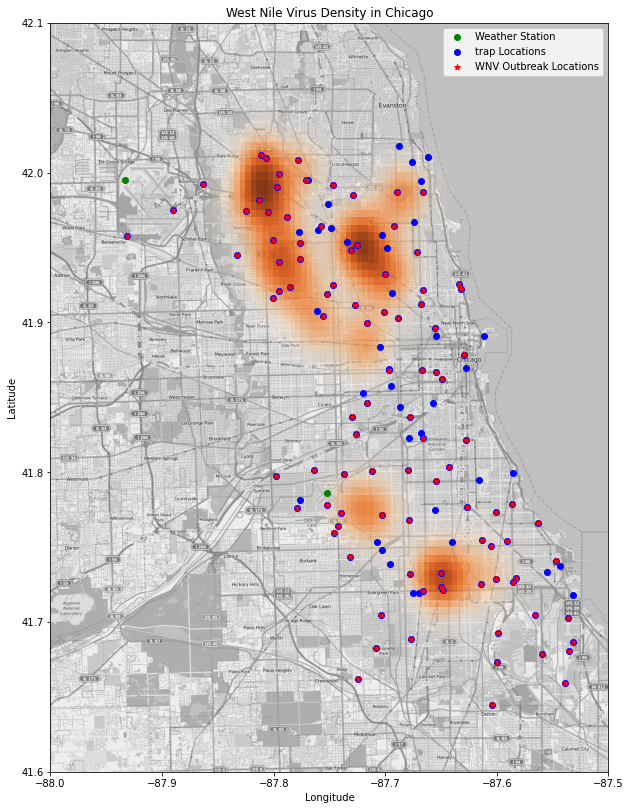

In [ ]:
alpha_cm = plt.cm.Oranges
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
X = spray[['Longitude', 'Latitude']].drop_duplicates().values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

# Weather Station locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='o', color='g', label='Weather Station')

# trap locations
trap_locations = train[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='o', c='b', label='trap Locations')

# wnn outbreak locations
wnv_locations = train[train['WnvPresent'] != 0][['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')

plt.title('West Nile Virus Density in Chicago')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('heatmap.png')

We wanted to get a better visual of what our data was telling us geographically. The green circles are where the weather stations located, the blue circles indicate the location of the traps placed for catching mosquitoes, the red stars indicate the location of the WNV outbreak and the orange markings describe the areas that were sprayed. Area with the darker orange indicates that the region has more spray concentration area and the area with lighter red means that less spray concentration area.

From the map, we have discovered that all the traps are pretty spread out but the spray didn't covered most of the WNV outbreak area. There must be a reason for this, let's see if any other visuals will help explain this mystery.

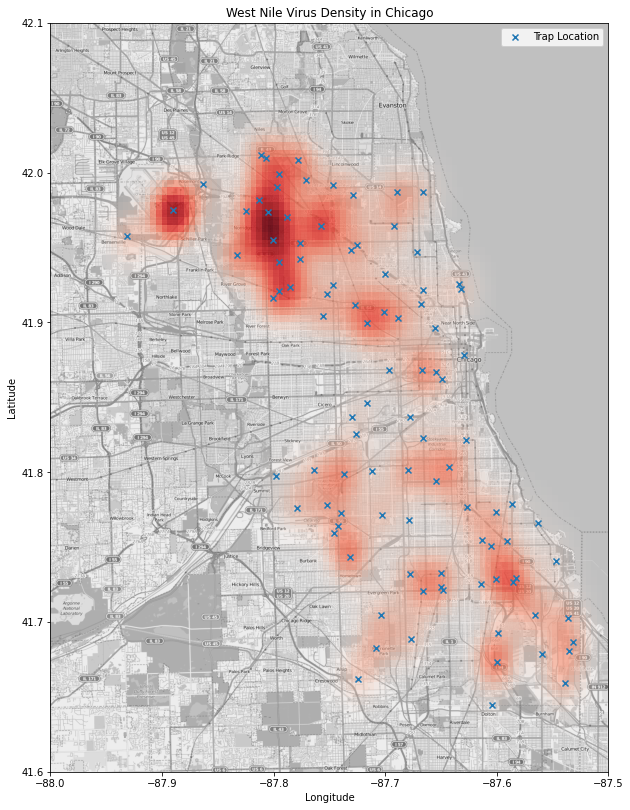

In [ ]:
alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
wnv = train[train['WnvPresent'] == 1]
wnv = wnv.groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
X = wnv[['Longitude', 'Latitude']].values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

#Trap locations
locations = wnv[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x', label='Trap Location')


plt.title('West Nile Virus Density in Chicago')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('heatmap.png')

This map helps to identify the density of the traps carrying mosquitoes with WNV. Area with the darker red indicates that the region has more mosquitoes that carry the WNV and the area with lighter red means that less virus density area. The map help with indicating which areas have a higher priority when it comes to anti WNV sprays.

In [ ]:
train['Species'].value_counts(ascending=True).plot(kind='barh', figsize=(6,5), color='#8383EC')
plt.title('Total number of samples collected for each species', fontsize=15, y = 1.05);

                        NumMosquitos  WnvPresent
Species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44671         240
CULEX PIPIENS/RESTUANS         66268         262
CULEX RESTUANS                 23431          49
CULEX SALINARIUS                 145           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  510           0


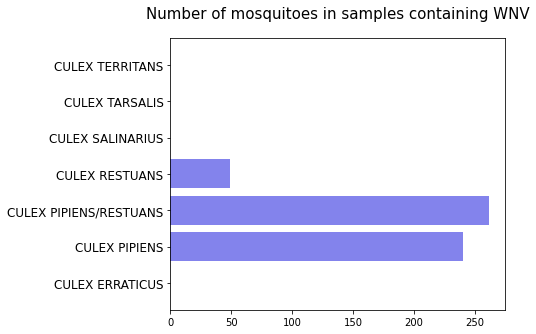

In [ ]:
mos_wnv = train[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum()
print(mos_wnv)

# reset the index after groupby
mos_wnv.reset_index(inplace=True)

plt.figure(figsize=(6,5))
plt.barh(mos_wnv['Species'], mos_wnv['WnvPresent'], color='#8383EC')
plt.title('Number of mosquitoes in samples containing WNV', fontsize=15, y=1.05)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,5))

# plot sampling efforts by year
train['Year'].value_counts().plot(kind = 'barh', ax = ax[0], color='#8383EC')
ax[0].set_title('Sampling efforts by year', fontsize=16)
ax[0].set_ylabel('Year', fontsize=14)
ax[0].set_xlabel('Total number of traps sampled',fontsize=14)

sns.lineplot(data = train, x='Month', y='WnvPresent', hue='Year', ci = None, 
             palette = 'coolwarm', ax = ax[1])
ax[1].legend(fontsize = 13)
ax[1].set_title('monthly WNV occurrences by year', fontsize=16)
ax[1].set_xlabel('Month',fontsize=14)
ax[1].set_ylabel('WNV occurrences',fontsize=14)

plt.tight_layout()

/opt/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


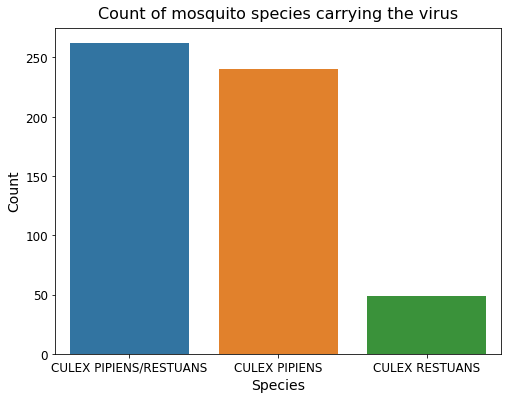

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(train[train['WnvPresent']==1]['Species'])
plt.title('Count of mosquito species carrying the virus', fontsize=16, y=1.01)
plt.tick_params(labelsize=12)
plt.xlabel('Species', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

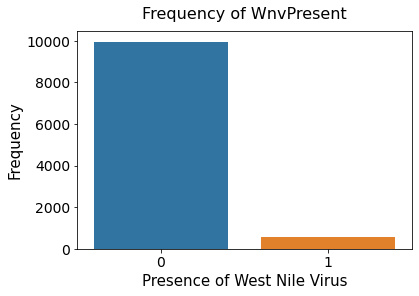

In [ ]:
# The target is imbalanced, which will be taken care of before modelling is done.
sns.barplot(x=[0,1], y=train['WnvPresent'].value_counts())
plt.xlabel('Presence of West Nile Virus', fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.tick_params(labelsize=14)
plt.title('Frequency of WnvPresent',fontsize=16, y=1.03)
plt.show()

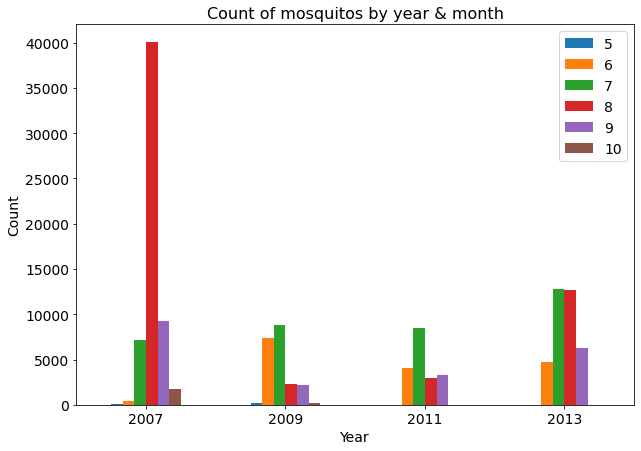

In [ ]:
train.groupby(['Year','Month'])['NumMosquitos'].sum().unstack().plot.bar(figsize=(10,7))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of mosquitos by year & month', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend(fontsize=14)
plt.show()

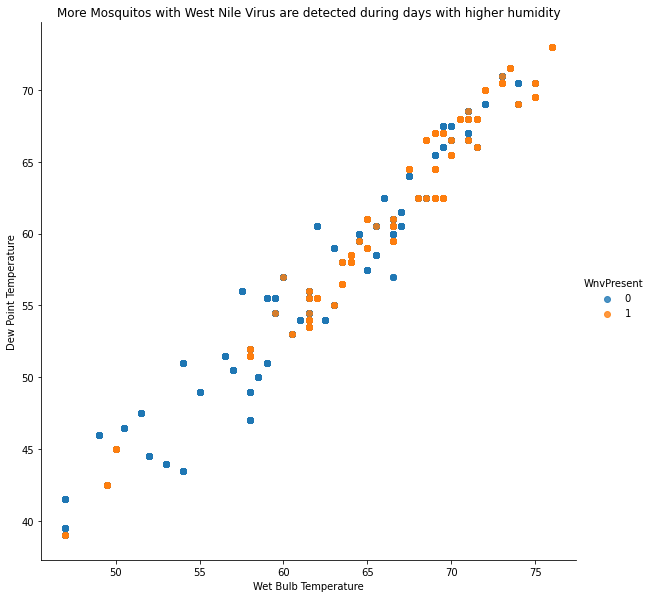

In [ ]:
sns.lmplot( x='WetBulb', y='DewPoint', data=merged_df, fit_reg=False, hue='WnvPresent', height=8)
plt.title('More Mosquitos with West Nile Virus are detected during days with higher humidity')
plt.xlabel('Wet Bulb Temperature')
plt.ylabel('Dew Point Temperature');

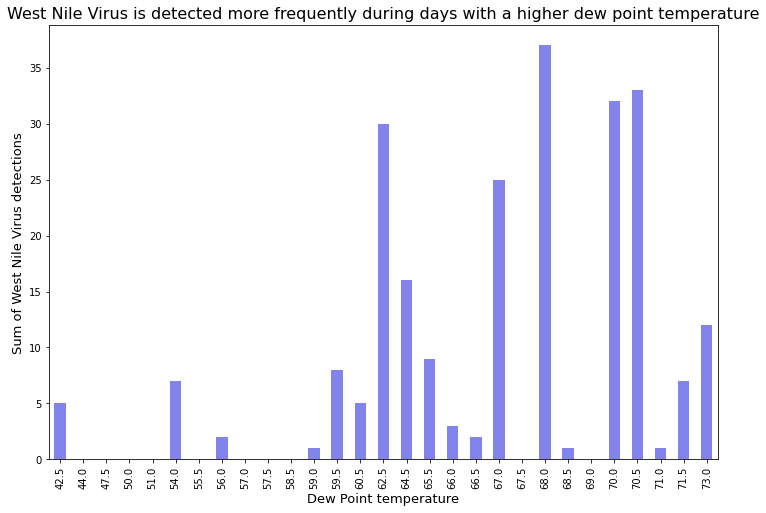

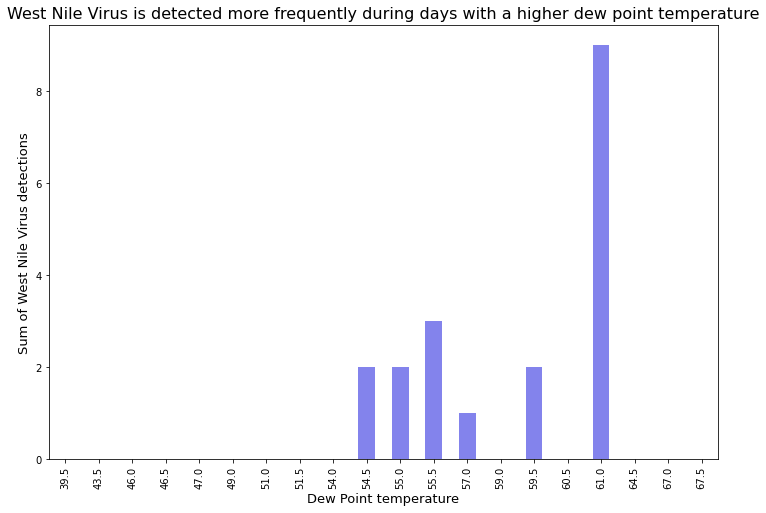

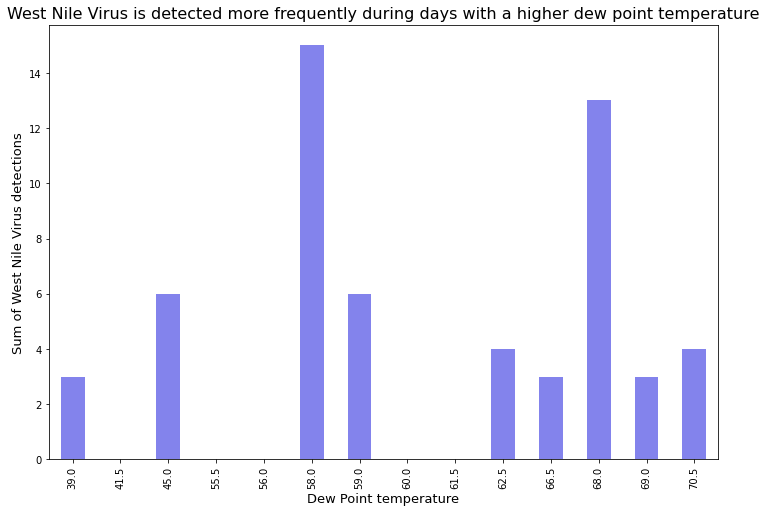

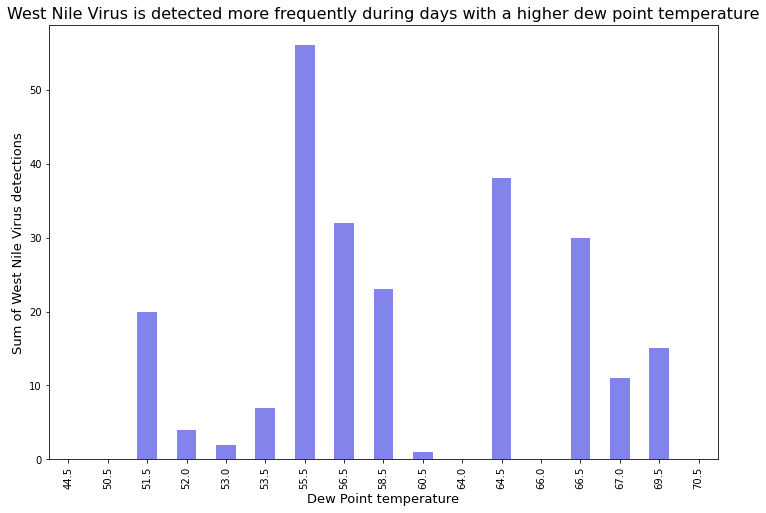

In [ ]:
for x in merged_df['Year'].unique():
    plt.figure(figsize=(12,8))
    merged_df[merged_df['Year']==x].groupby(['DewPoint'])['WnvPresent'].sum().plot.bar(color='#8383EC') 
    plt.title("West Nile Virus is detected more frequently during days with a higher dew point temperature", fontsize=16)
    plt.xlabel("Dew Point temperature", fontsize =13)
    plt.xticks(rotation=90)
    plt.ylabel("Sum of West Nile Virus detections", fontsize=13)

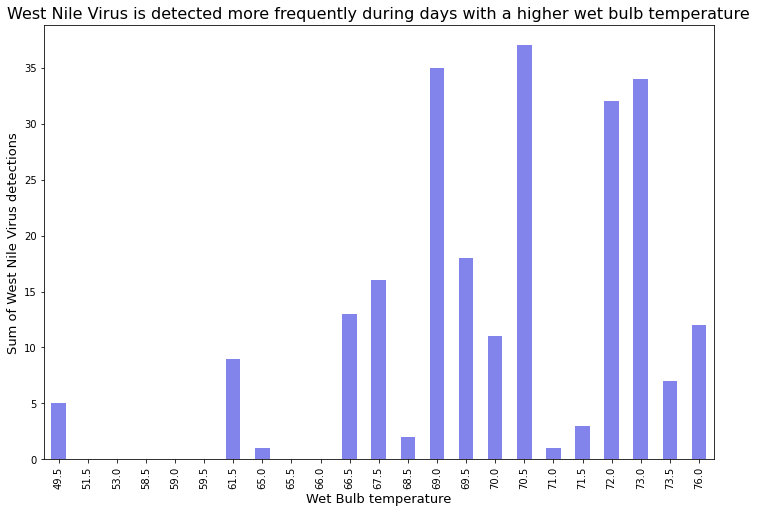

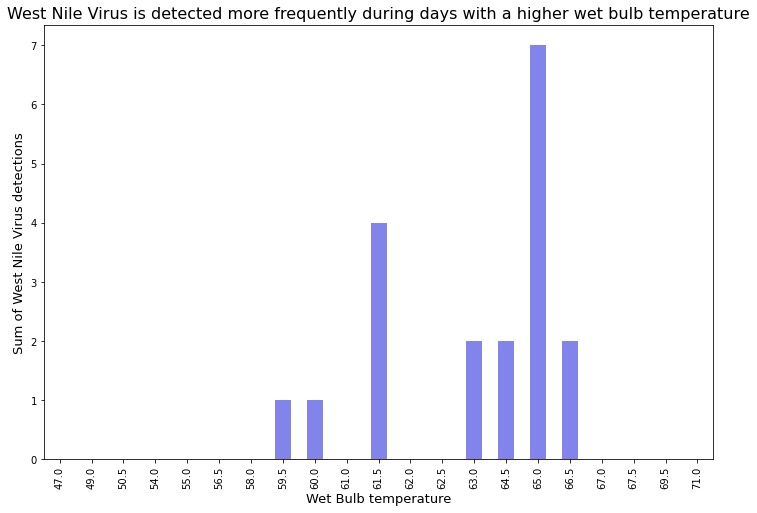

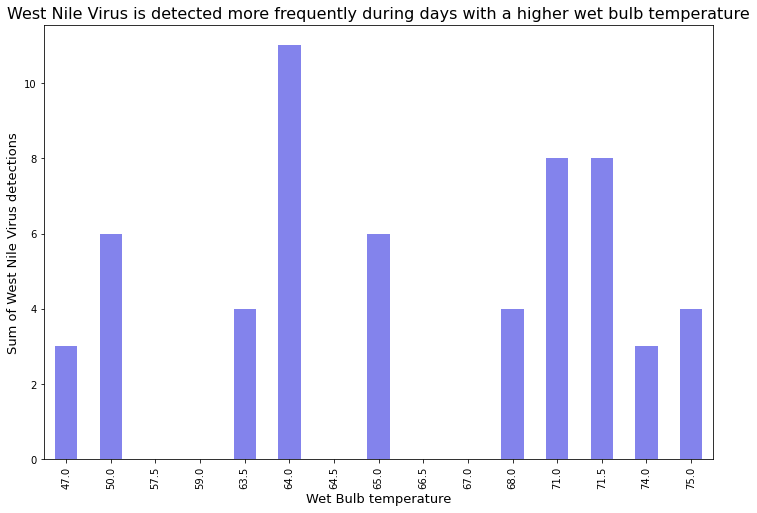

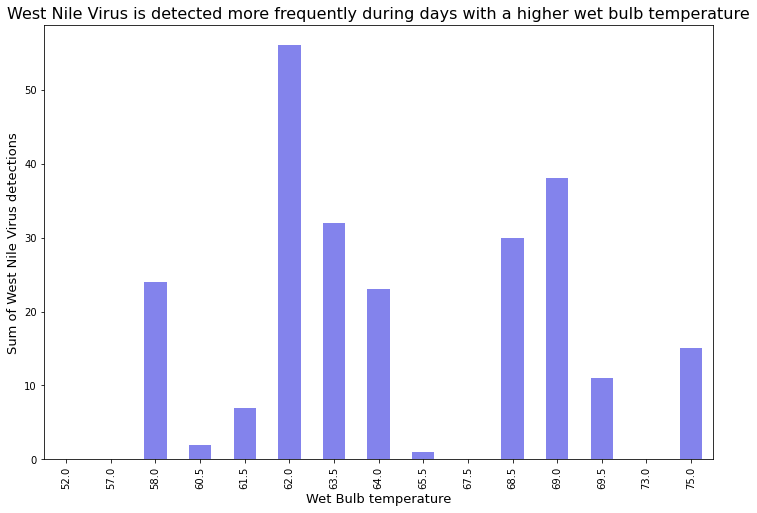

In [ ]:
for x in merged_df['Year'].unique():
    plt.figure(figsize=(12,8))
    merged_df[merged_df['Year']==x].groupby(['WetBulb'])['WnvPresent'].sum().plot.bar(color='#8383EC') 
    plt.title("West Nile Virus is detected more frequently during days with a higher wet bulb temperature", fontsize=16)
    plt.xlabel("Wet Bulb temperature", fontsize =13)
    plt.xticks(rotation=90)
    plt.ylabel("Sum of West Nile Virus detections", fontsize=13)

In [ ]:
def twin_plot(fea1, fea2):
    for x in merged_df['Year'].unique():
        fig, ax1 = plt.subplots(figsize=(12,6))

        sns.lineplot(x=merged_df[merged_df['Year']==x]['Date'], y=merged_df[merged_df['Year']==x][fea1],
                     ci=None, color='#8383EC', label=f'{fea1}', ax=ax1)
        ax1.set_xlabel('Date', fontsize=13)
        ax1.set_ylabel(f'{fea1}', fontsize=13, color='#8383EC')
        ax1.legend(loc=2)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70);

        new = merged_df[merged_df['Year']==x].groupby(['Date'])[fea2].sum()
        df_new = pd.DataFrame(new)

        ax2 = ax1.twinx()
        sns.lineplot(x=df_new.index, y=df_new[fea2],
                     ci=None, color='r', label=f'{fea2}', ax=ax2)
        ax2.set_ylabel(f'{fea2}', fontsize=13, color='r')
        ax2.legend(loc=1)

        plt.title(f'{fea1} and {fea2} in {x}')

        fig.tight_layout()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


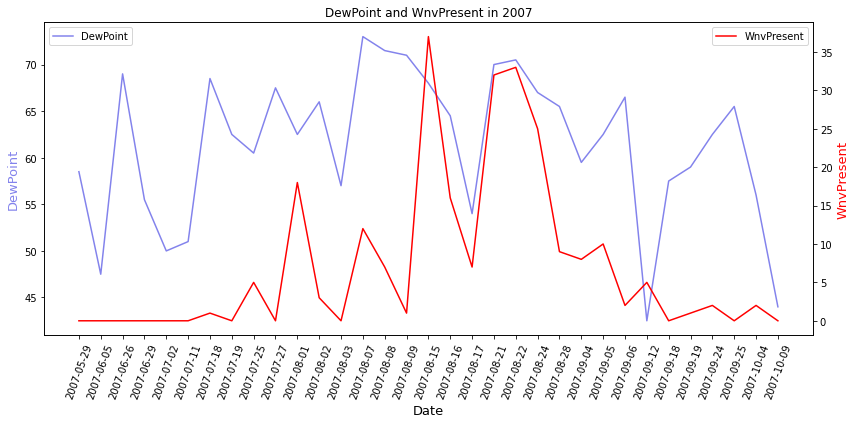

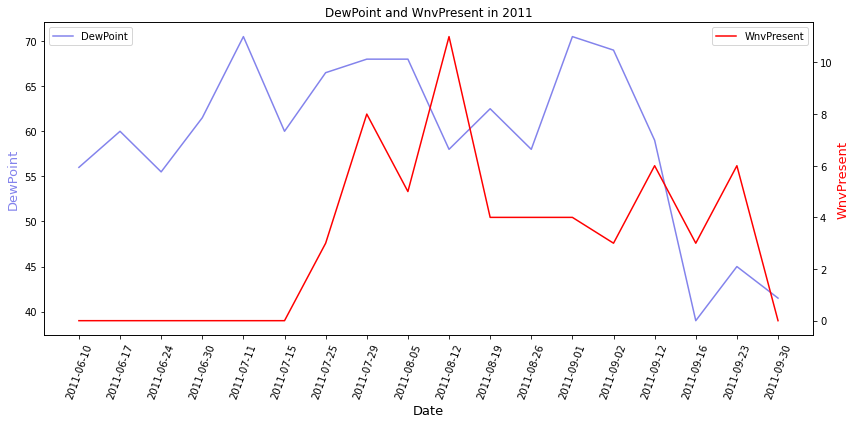

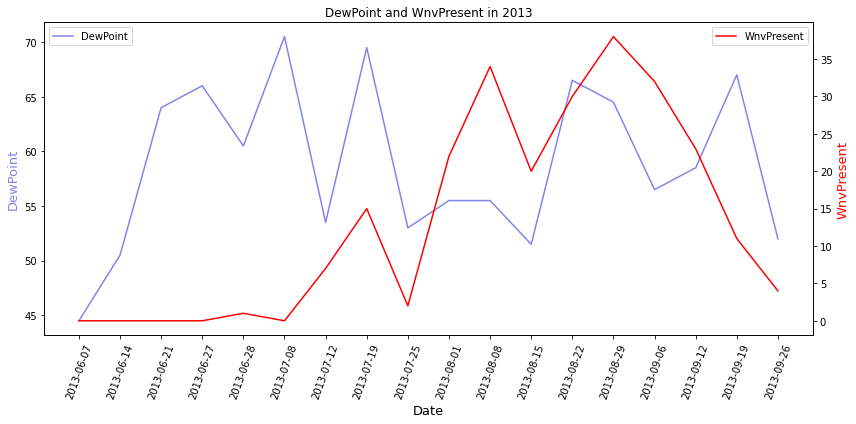

In [ ]:
twin_plot('DewPoint','WnvPresent')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


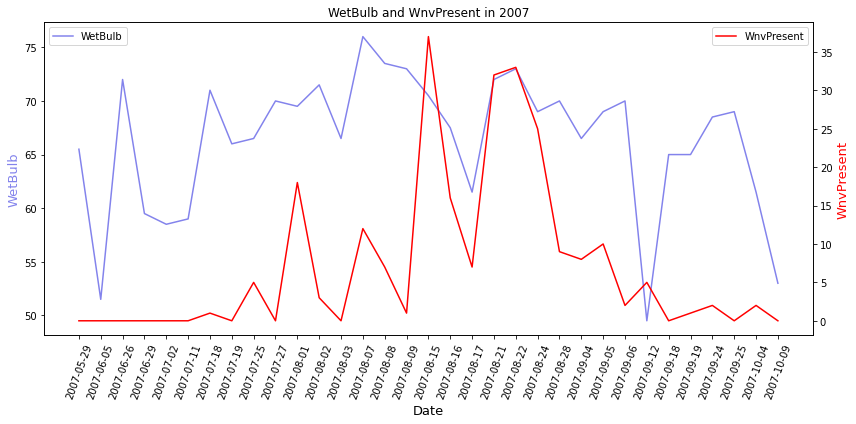

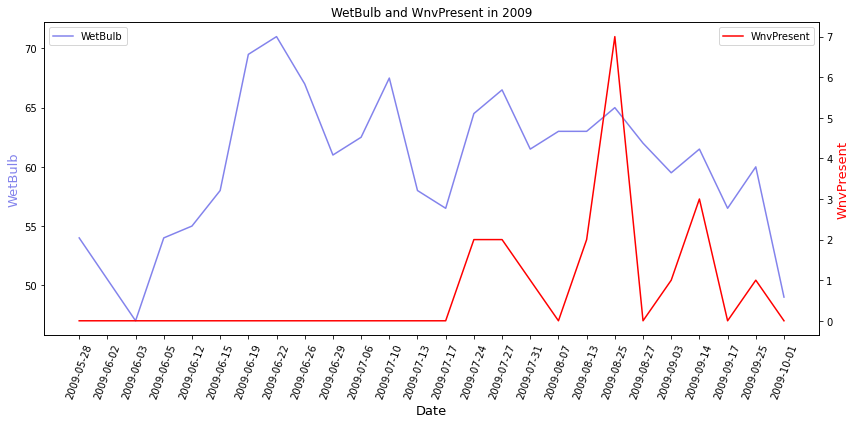

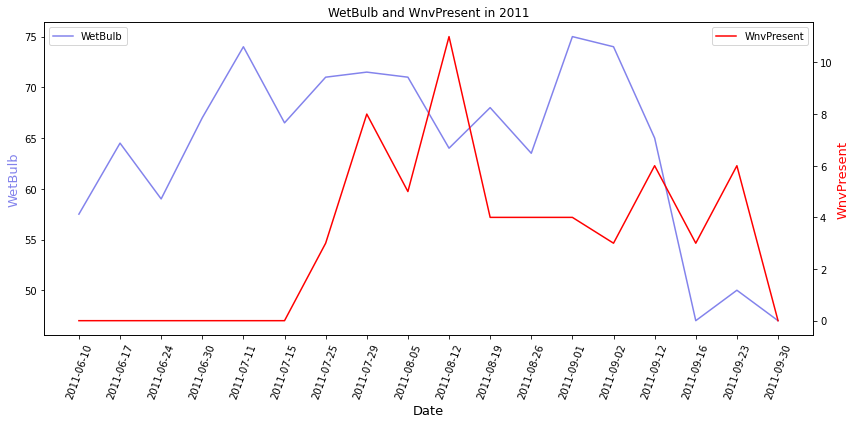

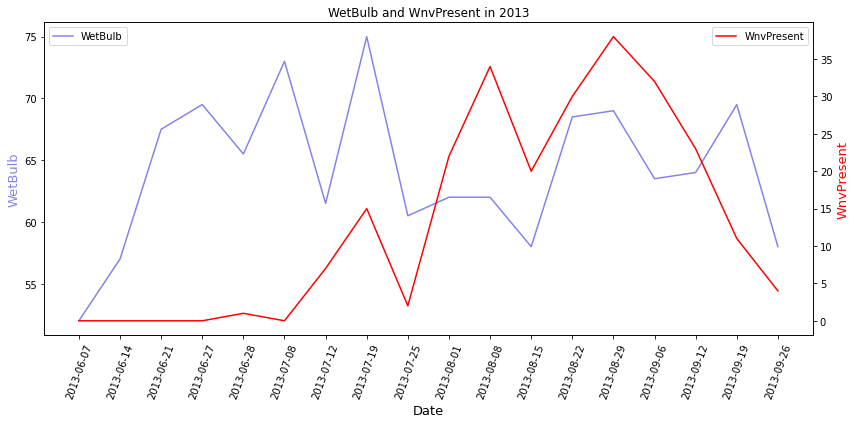

In [ ]:
twin_plot('WetBulb','WnvPresent')

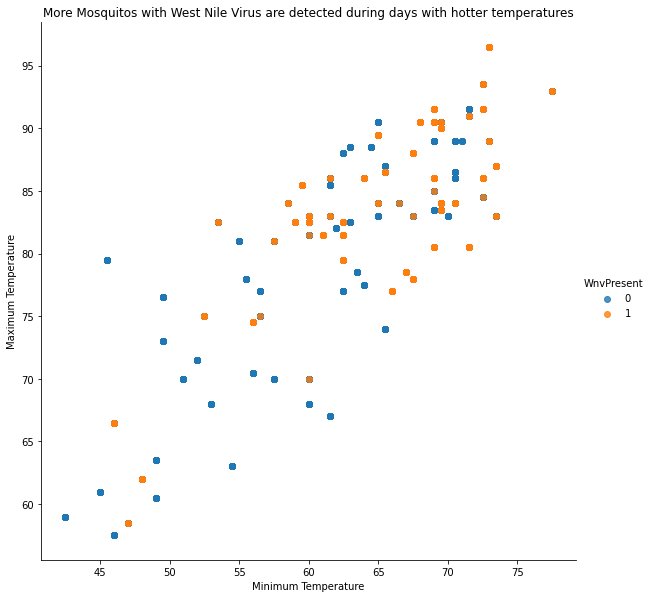

In [ ]:
sns.lmplot( x='Tmin', y='Tmax', data=merged_df, fit_reg=False, hue='WnvPresent', height=8)
plt.title('More Mosquitos with West Nile Virus are detected during days with hotter temperatures')
plt.xlabel('Minimum Temperature')
plt.ylabel('Maximum Temperature');

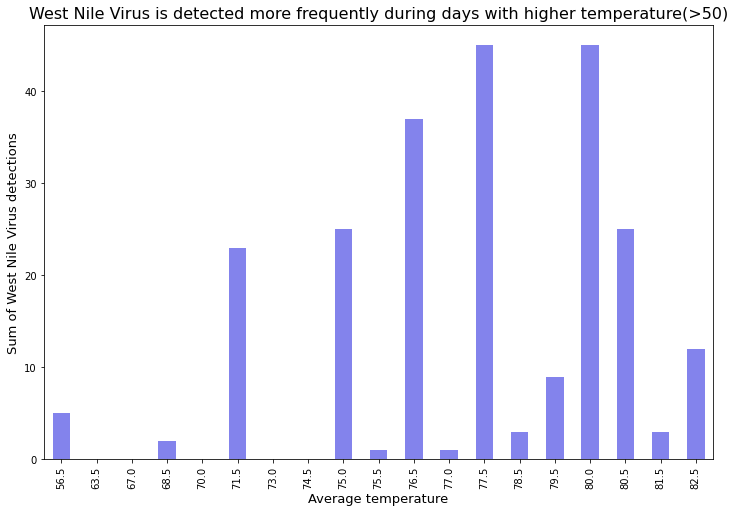

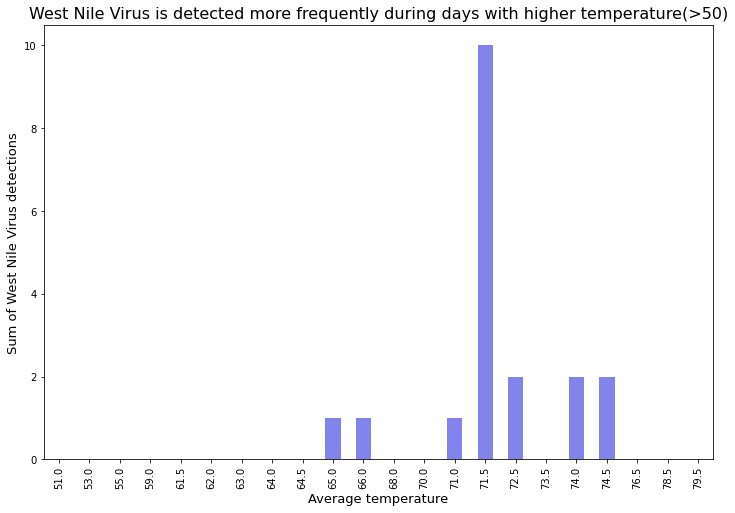

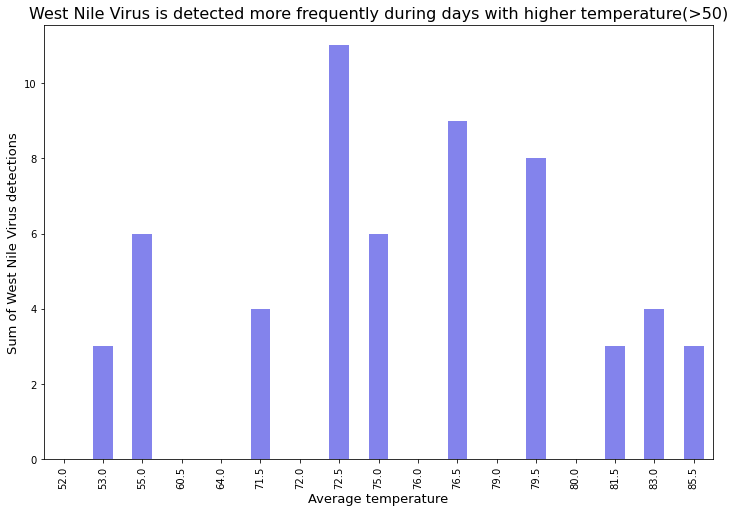

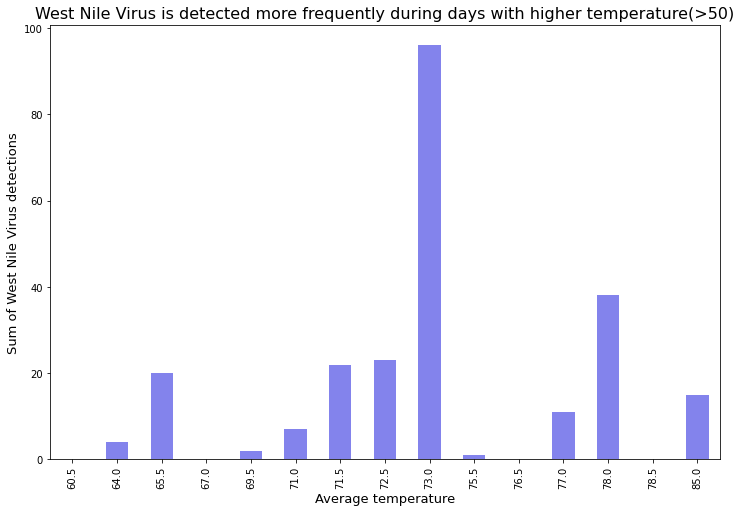

In [ ]:
for x in merged_df['Year'].unique():
    plt.figure(figsize=(12,8))
    merged_df[merged_df['Year']==x].groupby(['Tavg'])['WnvPresent'].sum().plot.bar(color='#8383EC') 
    plt.title("West Nile Virus is detected more frequently during days with higher temperature(>50)", fontsize=16)
    plt.xlabel("Average temperature", fontsize =13)
    plt.xticks(rotation=90)
    plt.ylabel("Sum of West Nile Virus detections", fontsize=13)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


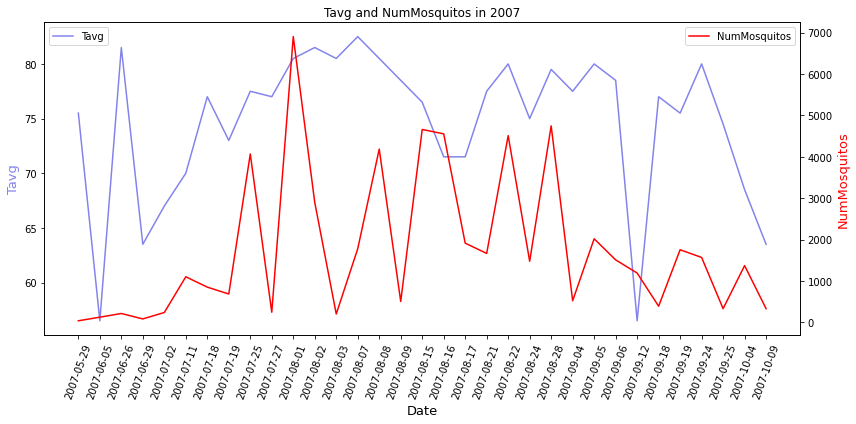

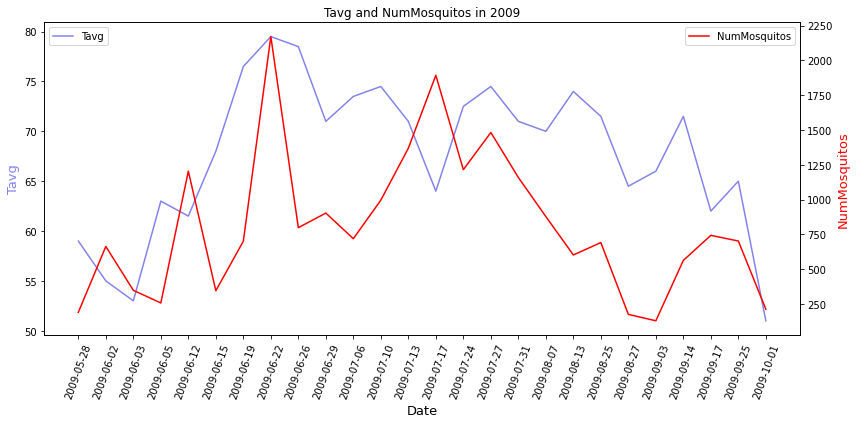

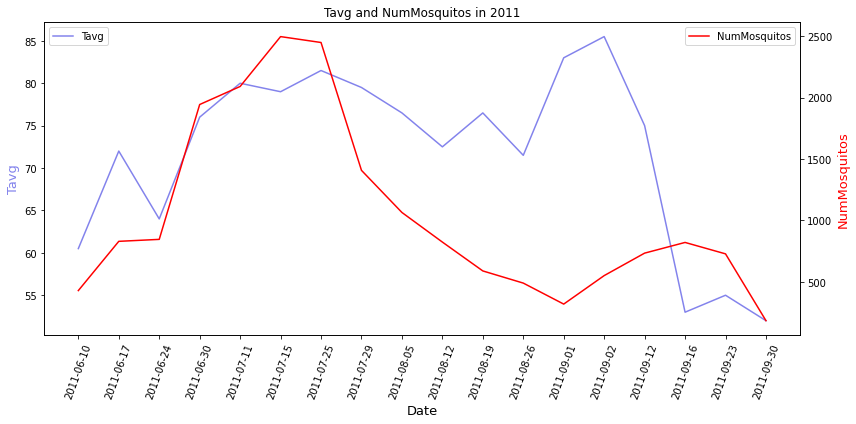

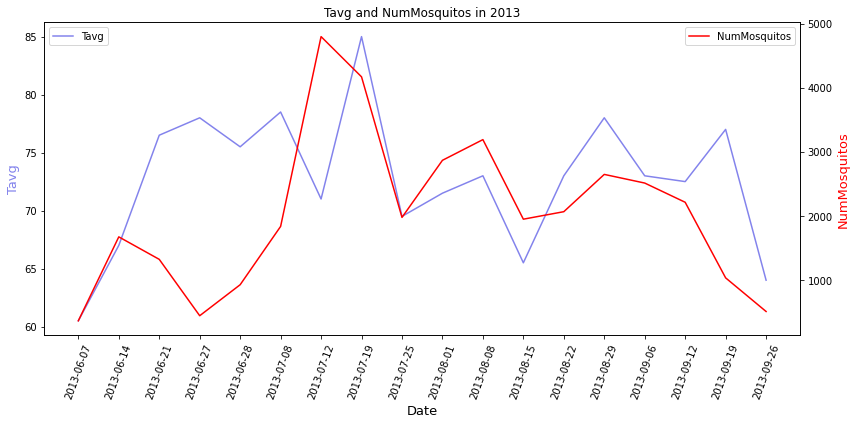

In [ ]:
twin_plot('Tavg','NumMosquitos')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


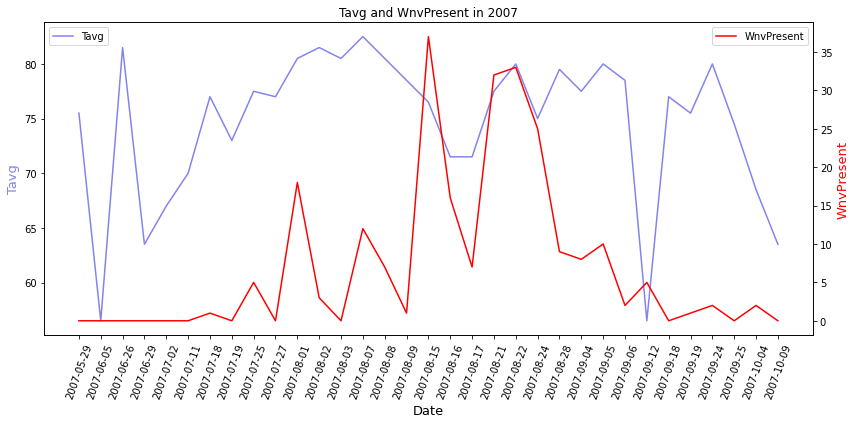

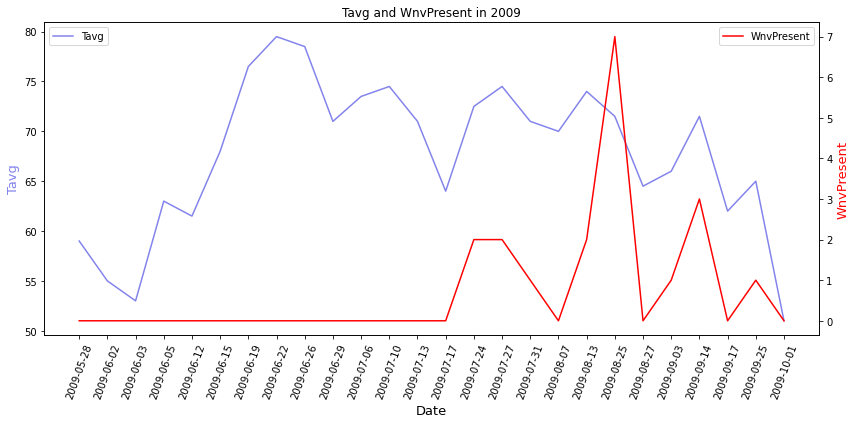

In [ ]:
twin_plot('Tavg','WnvPresent')

In [ ]:
# Highest number of WMN present in Jul, Aug
train.groupby(['Year','Month'])['WnvPresent'].sum().unstack().plot.bar(figsize=(15,10))
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Count of wnv carried by mosquitos by year & month', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend(fontsize=14)
plt.show()

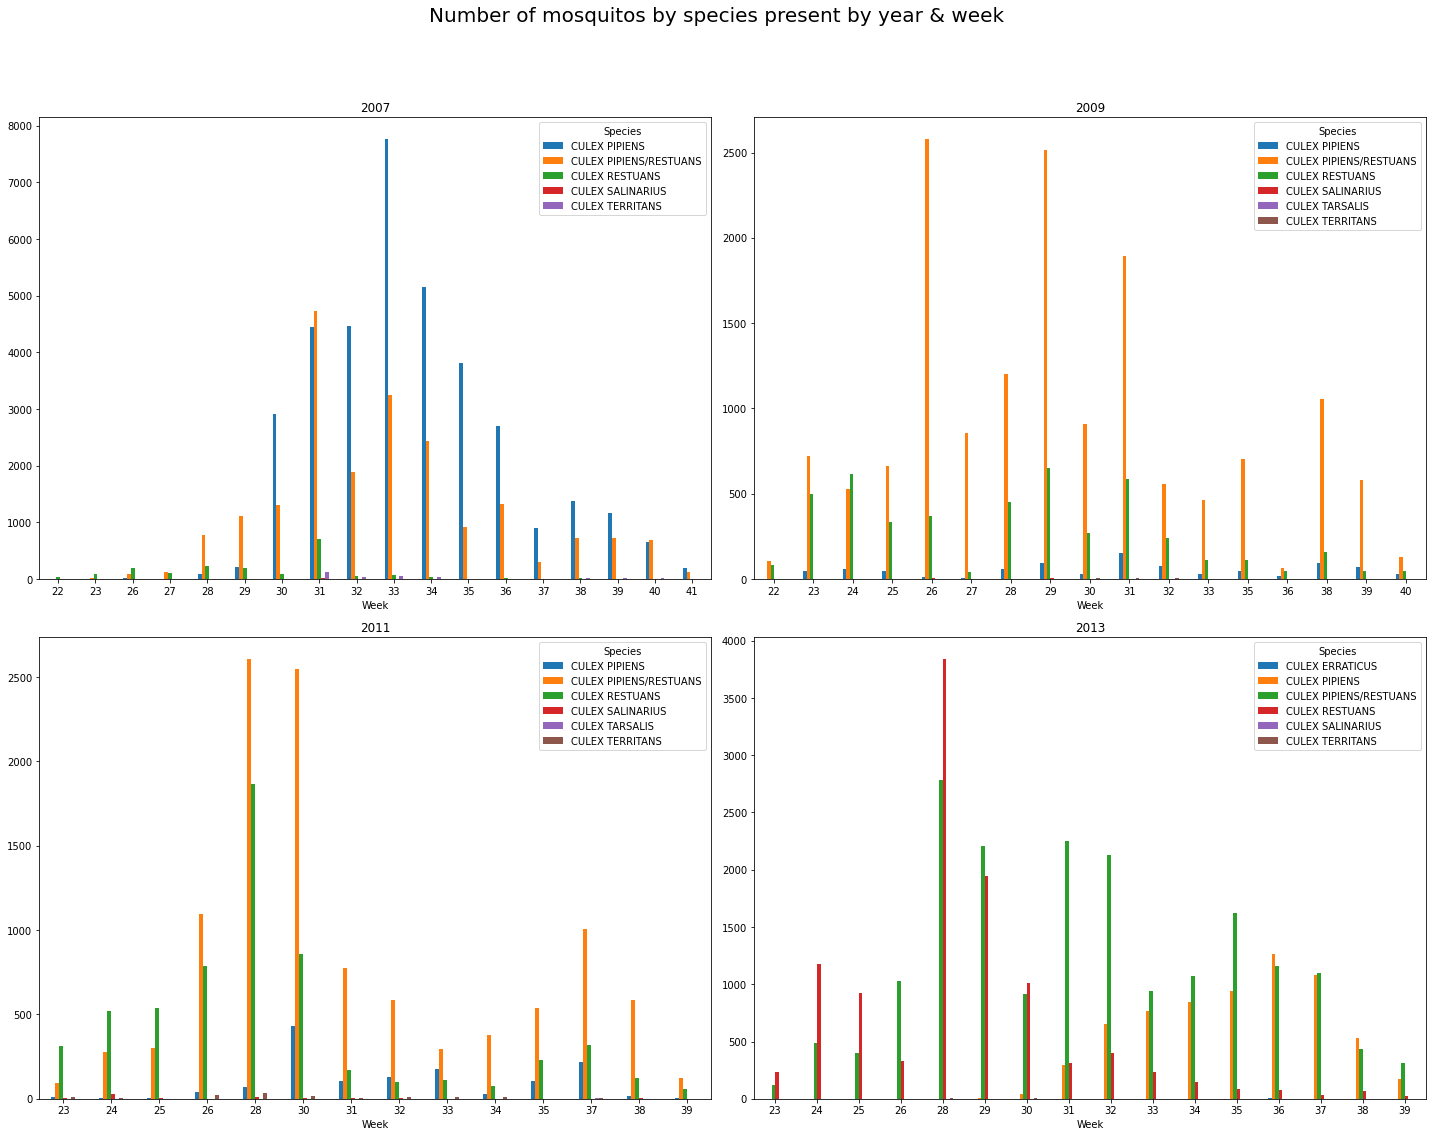

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of mosquitos by species present by year & week', fontsize=20, y=1.05)
for i, y in enumerate(train['Year'].unique()):
    train[train['Year']==y].groupby(['Week','Species'])['NumMosquitos'].sum().unstack(fill_value=0).plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
plt.tight_layout()

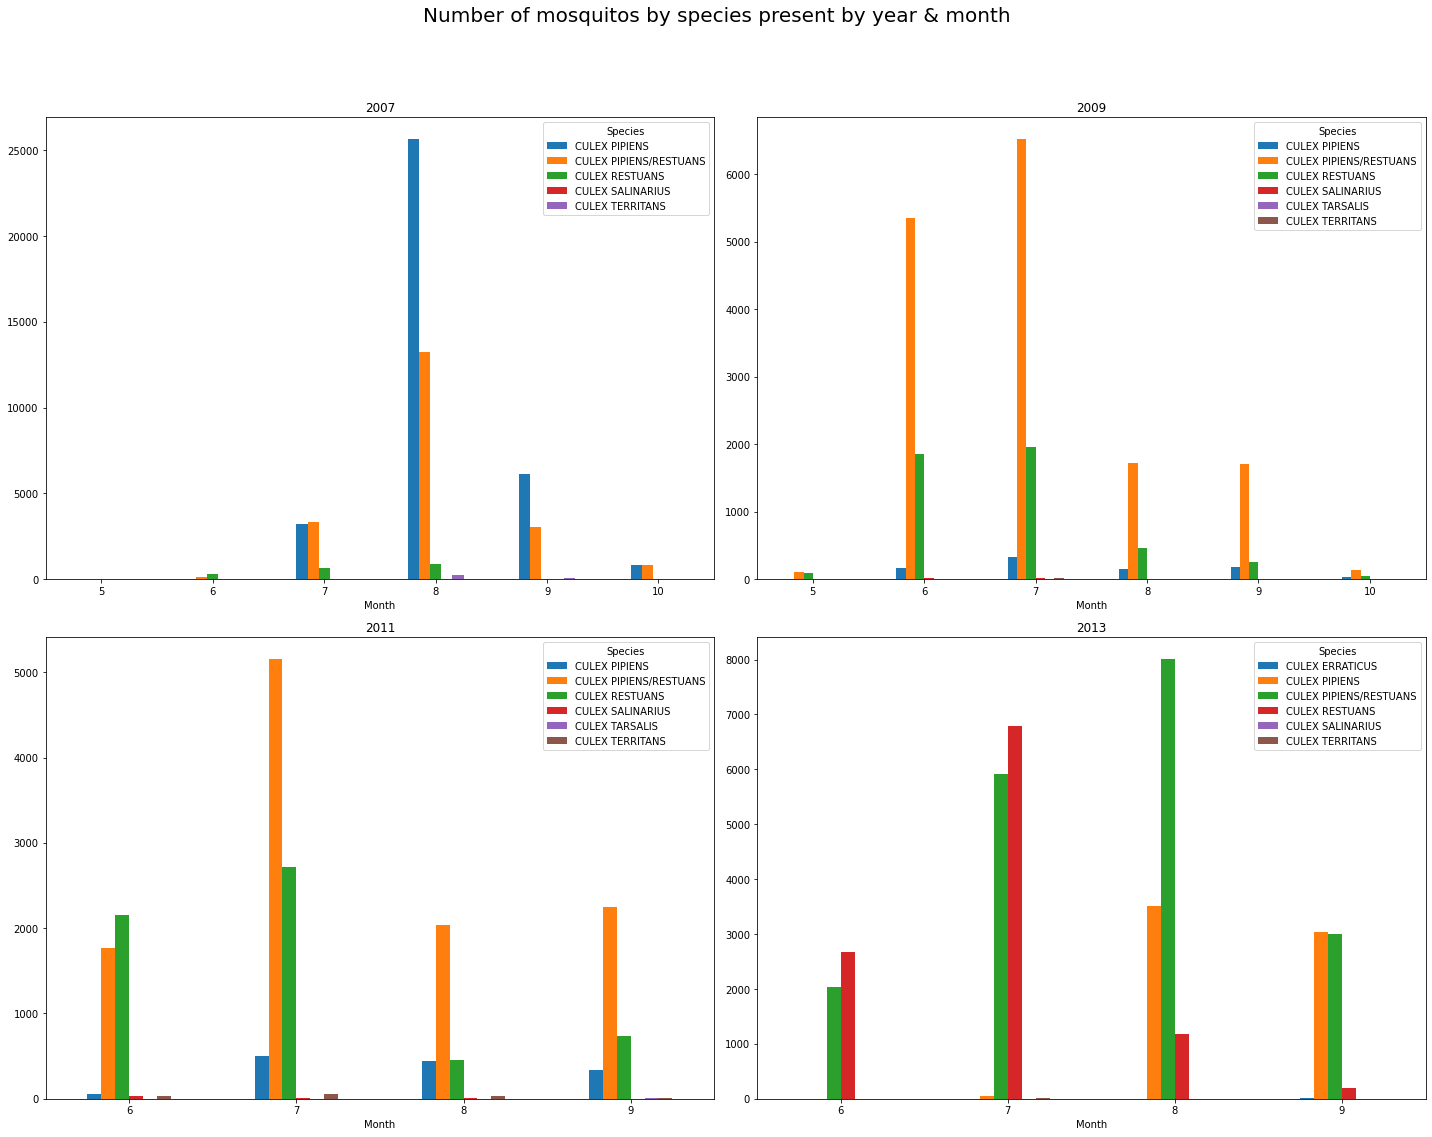

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of mosquitos by species present by year & month', fontsize=20, y=1.05)
for i, y in enumerate(train['Year'].unique()):
    train[train['Year']==y].groupby(['Month','Species'])['NumMosquitos'].sum().unstack(fill_value=0).plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
plt.tight_layout()

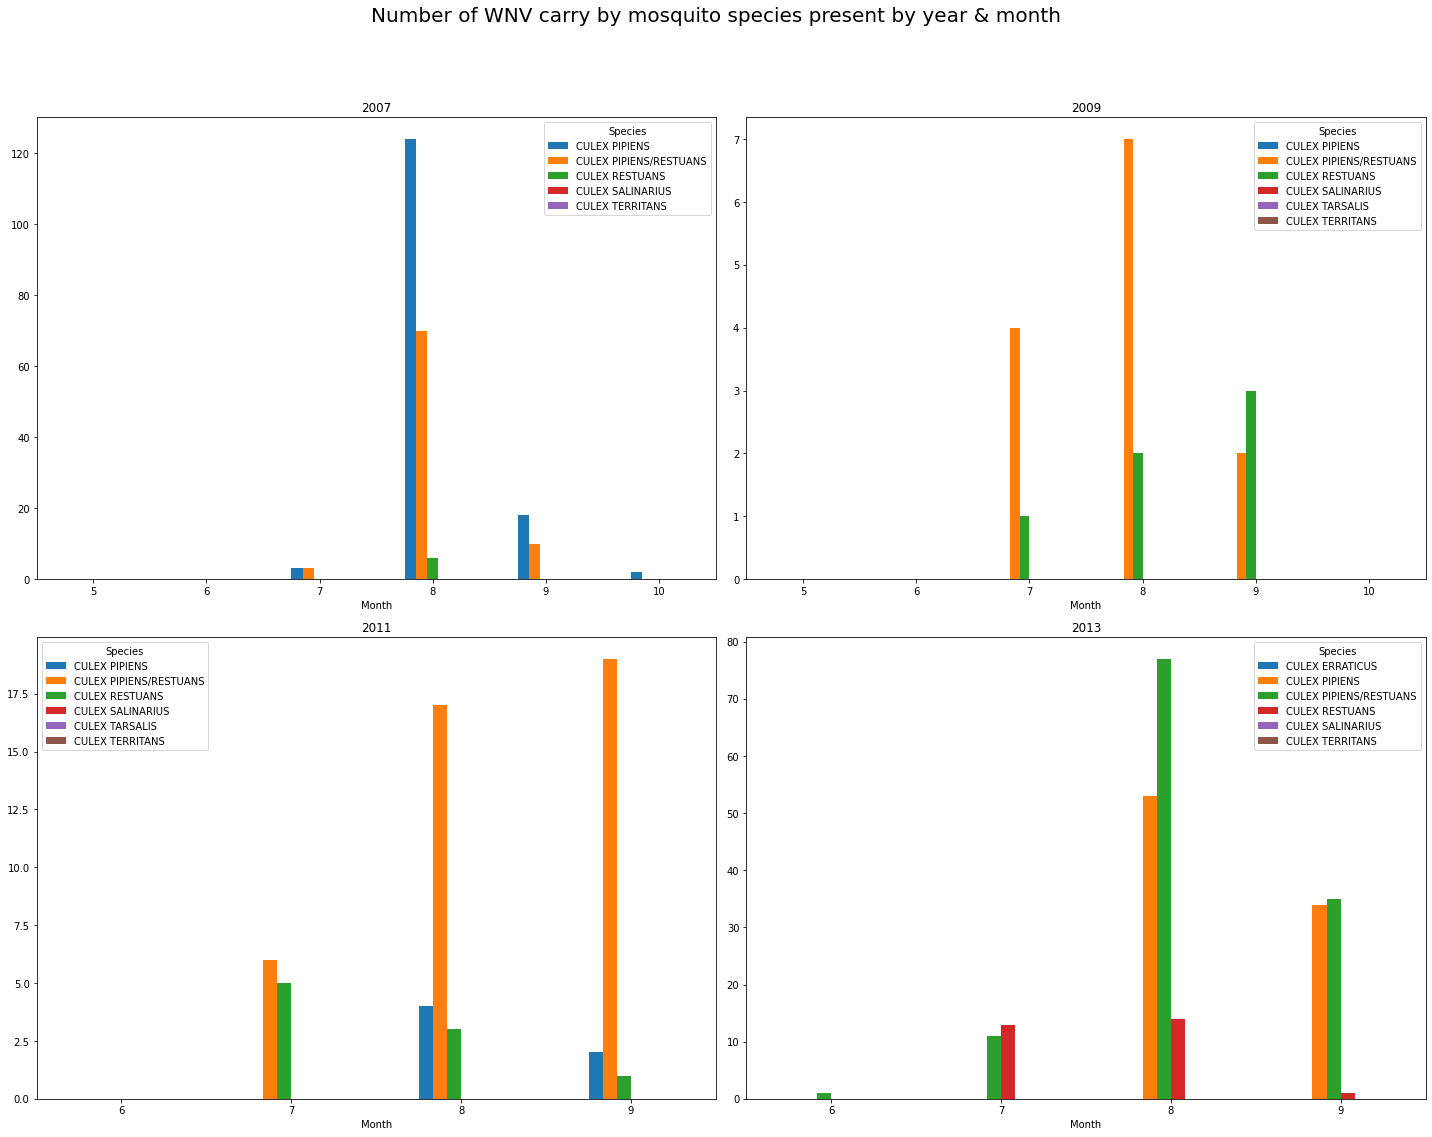

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of WNV carry by mosquito species present by year & month', fontsize=20, y=1.05)
for i, y in enumerate(train['Year'].unique()):
    train[train['Year']==y].groupby(['Month','Species'])['WnvPresent'].sum().unstack(fill_value=0).plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
plt.tight_layout()

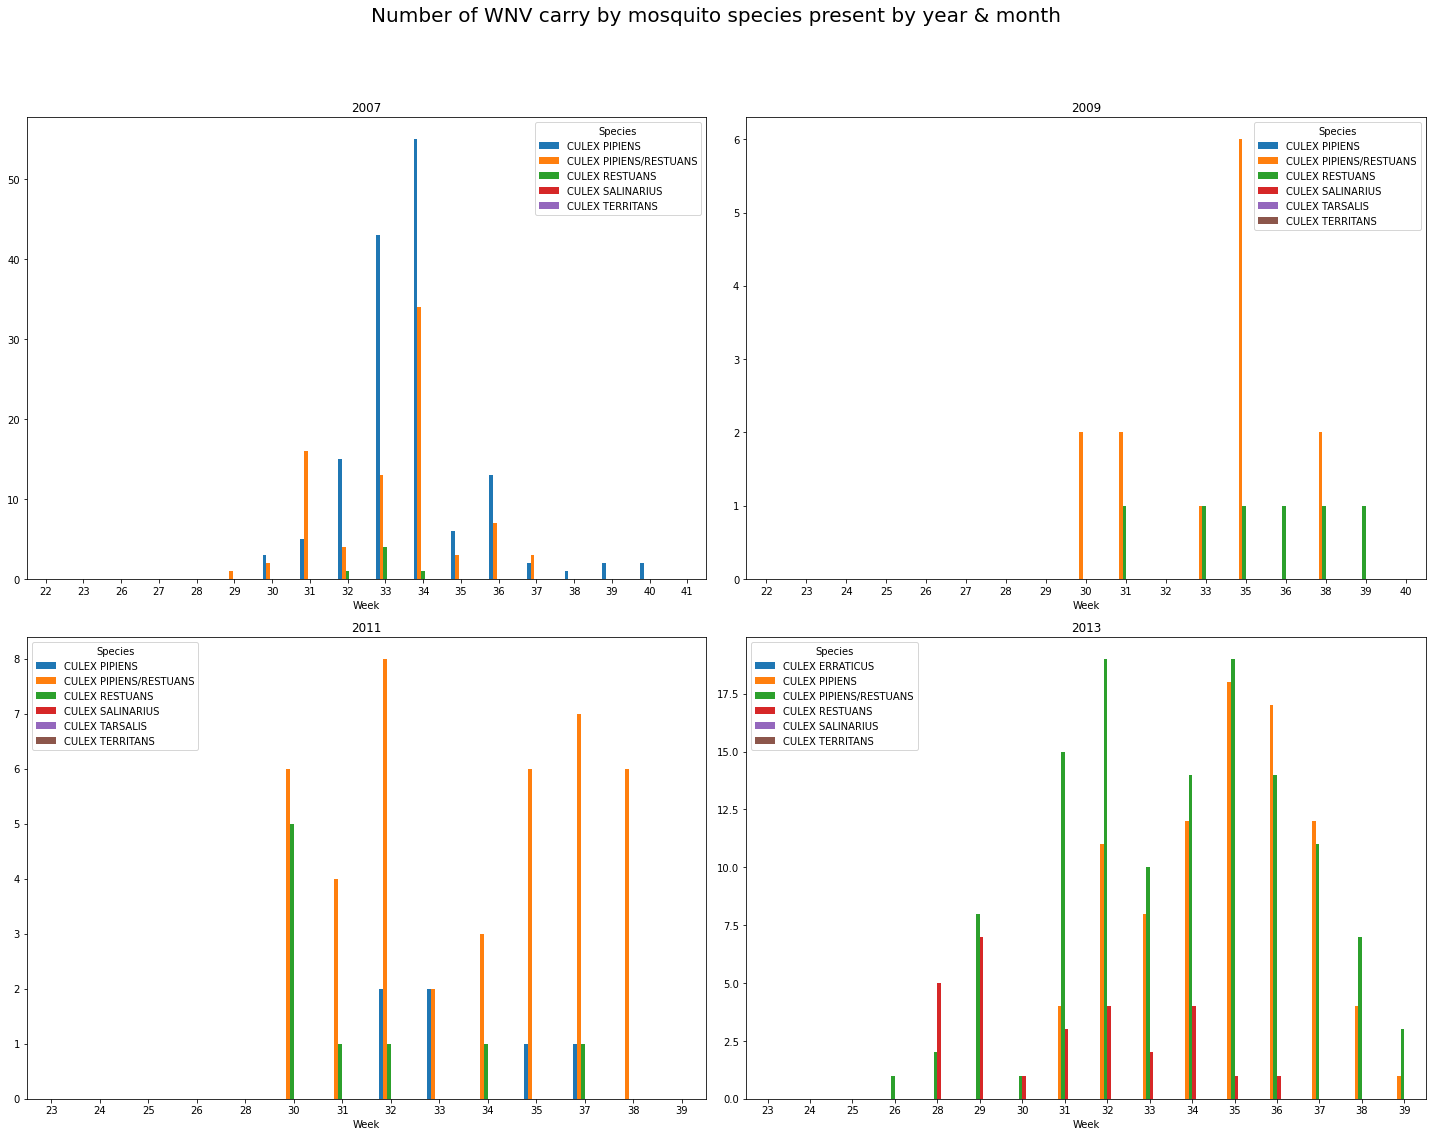

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of WNV carry by mosquito species present by year & month', fontsize=20, y=1.05)
for i, y in enumerate(train['Year'].unique()):
    train[train['Year']==y].groupby(['Week','Species'])['WnvPresent'].sum().unstack(fill_value=0).plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
plt.tight_layout()

In [ ]:
def twin_bar_plot(fea1, fea2):
    for x in merged_df['Year'].unique():
        fig, ax1 = plt.subplots(figsize=(12,6))
        
        kwargs = {'alpha':0.5}
        sns.barplot(x=merged_df[merged_df['Year']==x]['Month'], y=merged_df[merged_df['Year']==x][fea1],
                     ci=None, color='#8383EC', label=f'{fea1}', ax=ax1)
        ax1.set_xlabel('Date', fontsize=13)
        ax1.set_ylabel(f'{fea1}', fontsize=13, color='#8383EC')
        ax1.legend(loc=2)
        ax1.set_xticklabels(ax1.get_xticklabels());

        no_mosquito = merged_df[merged_df['Year']==x].groupby(['Month'])[fea2].sum()
        df_no_mosquito = pd.DataFrame(no_mosquito)

        ax2 = ax1.twinx()
        sns.barplot(x=df_no_mosquito.index, y=df_no_mosquito[fea2],
                     ci=None, color='r', label=f'{fea2}', ax=ax2, **kwargs)
        ax2.set_ylabel(f'{fea2}', fontsize=13, color='r')
        ax2.legend(loc=1)

        plt.title(f'{fea1} and {fea2} in {x}')

        fig.tight_layout()

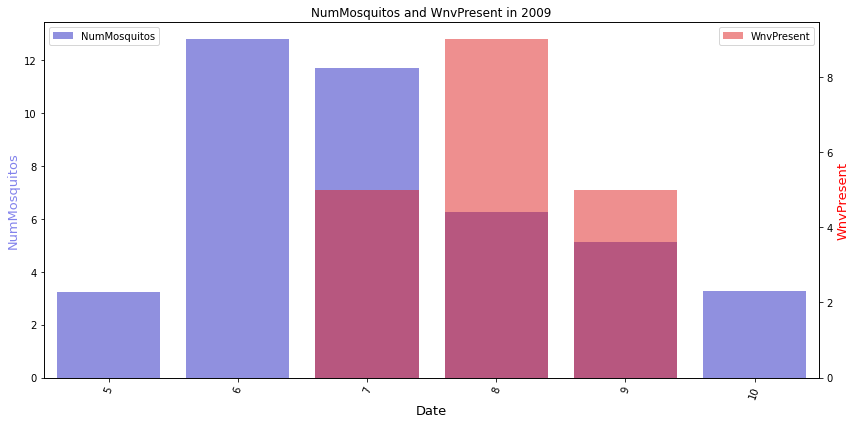

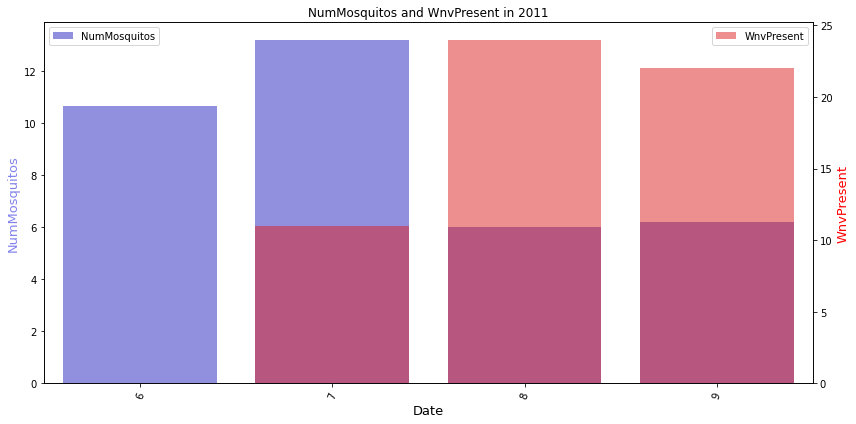

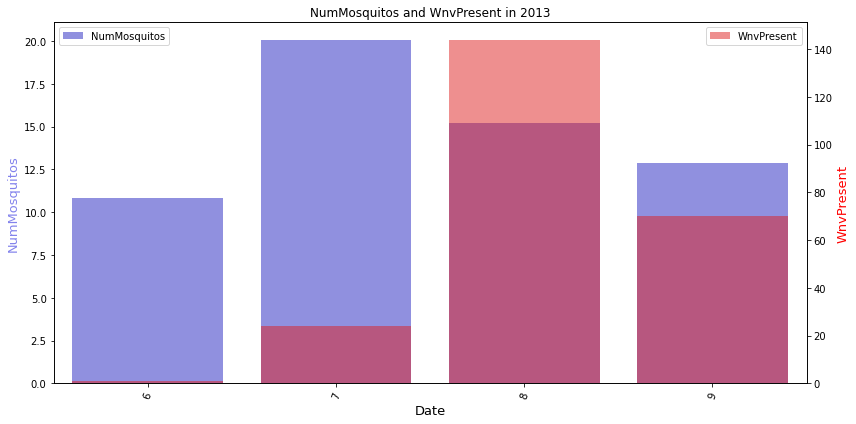

In [ ]:
twin_bar_plot('NumMosquitos','WnvPresent')

In [ ]:
spray['Year'] = pd.to_datetime(spray['Date']).apply(lambda x: x.year)
spray['Week'] = pd.to_datetime(spray['Date']).apply(lambda x: x.week)
merged_df = pd.merge(weather, train, on=['Date', 'Year', 'Week', 'Month', 'DayOfWeek'])
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [ ]:
def target_plot(target, color):
    for year in [2011, 2013]:
        fig, ax1 = plt.subplots(figsize=(10,4))
        temp_df = merged_df[merged_df['Year']==year].groupby(['Week'])[target].sum().to_frame()

        sns.lineplot(x=temp_df.index, y=temp_df[target],
                     ci=None, color=color, label=f'{target}', ax=ax1)
        ax1.set_ylabel(f'{target}', fontsize=13)
        ax1.legend(loc=1)
        
        if year in spray['Year'].unique():
            for date in spray[spray['Year'] == year].groupby('Week').mean().index:
                plt.axvline(date, linestyle='--', color='black', alpha=0.5, label='Spray')
        
        plt.legend([f'{target}', 'Spray'])
        plt.title(f'{target} in {year}')
        plt.tight_layout()

#### Analysing Spray Efficacy

Our spray dataset from the get-go is pretty limited in terms of usefulness as we only have two years in which spraying occured. In 2011, there were two days in which spraying was carried out. In 2013, spraying was much more extensive, and was carried out on 7 different days. Generally it seems that spraying doesn't have an observable effect on WnvPresent -- it would likely take larvacide instead of something like Zenivex, which is a mosquito adulticide.

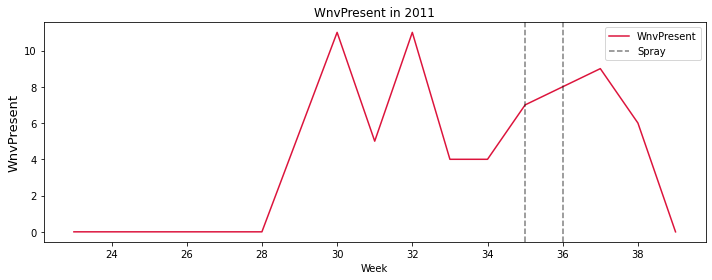

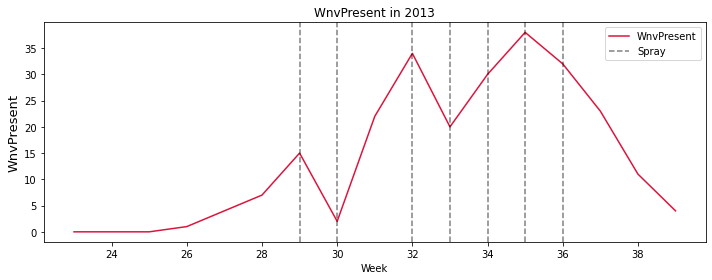

In [ ]:
# Spraying don't seem to have a clear/immediate effect on WNV found within traps
target_plot('WnvPresent', 'crimson')

It's hard to fully gauge the effects of the spraying based on our current data, but it seems that the spraying is helping to keep the mosquito population in control.

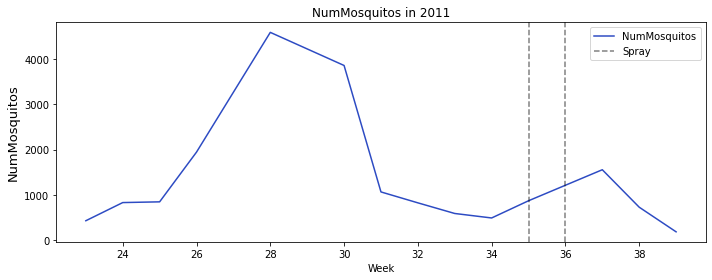

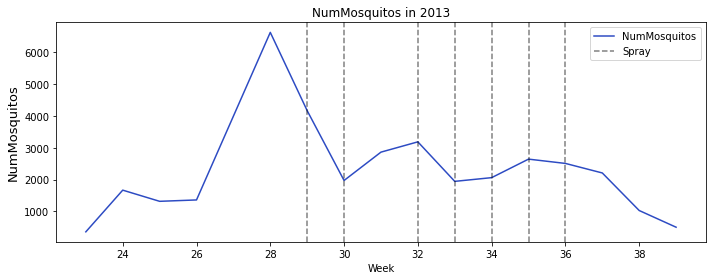

In [ ]:
# These sprays seem to have a limited effect on number of mosquitos found in traps
target_plot('NumMosquitos', '#2d4bc3')